In [1]:
import numpy as np
import pprint
import sys
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.gridworld import GridworldEnv

In [2]:
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()

In [31]:
# Taken from Policy Evaluation Exercise!

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + discount_factor * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < theta:
            break
    return np.array(V)

In [32]:
def policy_improvement(env, policy_eval_fn=policy_eval, discount_factor=1.0):
    """
    Policy Improvement Algorithm. Iteratively evaluates and improves a policy
    until an optimal policy is found.
    
    Args:
        env: The OpenAI envrionment.
        policy_eval_fn: Policy Evaluation function that takes 3 arguments:
            policy, env, discount_factor.
        discount_factor: gamma discount factor.
        
    Returns:
        A tuple (policy, V). 
        policy is the optimal policy, a matrix of shape [S, A] where each state s
        contains a valid probability distribution over actions.
        V is the value function for the optimal policy.
        
    """
    # Start with a random policy
    policy = np.ones([env.nS, env.nA]) / env.nA 
    
    while True:
        # get val func for current policy
        V = policy_eval_fn(policy, env, discount_factor)

        # assume policy is stable
        policy_convergent = True 

        # policy improvement loop
        for s in range(env.nS):
            old_action = np.argmax(policy[s])
            action_values = np.zeros(env.nA)
            for a in range(env.nA):
                for prob, next_state, reward, done in env.P[s][a]:
                    action_values[a] += prob * (reward + discount_factor * V[next_state])
            best_action = np.argmax(action_values)
            policy[s] = np.eye(env.nA)[best_action]
            if old_action != best_action:
                policy_convergent = False # policy changed
                
        if policy_convergent:
            break
    
    return policy, V

In [33]:
policy, v = policy_improvement(env)
print("Policy Probability Distribution:")
print(policy)
print("")

print("Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):")
print(np.reshape(np.argmax(policy, axis=1), env.shape))
print("")

print("Value Function:")
print(v)
print("")

print("Reshaped Grid Value Function:")
print(v.reshape(env.shape))
print("")



Policy Probability Distribution:
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

Reshaped Grid Policy (0=up, 1=right, 2=down, 3=left):
[[0 3 3 2]
 [0 0 0 2]
 [0 0 1 2]
 [0 1 1 0]]

Value Function:
[ 0. -1. -2. -3. -1. -2. -3. -2. -2. -3. -2. -1. -3. -2. -1.  0.]

Reshaped Grid Value Function:
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]



In [34]:
# Test the value function
expected_v = np.array([ 0, -1, -2, -3, -1, -2, -3, -2, -2, -3, -2, -1, -3, -2, -1,  0])
np.testing.assert_array_almost_equal(v, expected_v, decimal=2)

In [35]:
import matplotlib.pyplot as plt

def plot_value_function(V, shape, title="Value Function"):
    plt.figure(figsize=(6,6))
    plt.imshow(V.reshape(shape), cmap='coolwarm', interpolation='none')
    plt.colorbar()
    plt.title(title)
    plt.show()

In [36]:
def plot_policy(policy, shape, title="Policy"):
    # 0=up, 1=right, 2=down, 3=left
    action_arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    policy_grid = np.argmax(policy, axis=1).reshape(shape)
    plt.figure(figsize=(6,6))
    for i in range(shape[0]):
        for j in range(shape[1]):
            action = policy_grid[i, j]
            plt.text(j, i, action_arrows[action], ha='center', va='center', fontsize=24)
    plt.xlim(-0.5, shape[1]-0.5)
    plt.ylim(shape[0]-0.5, -0.5)
    plt.title(title)
    plt.grid(True)
    plt.show()

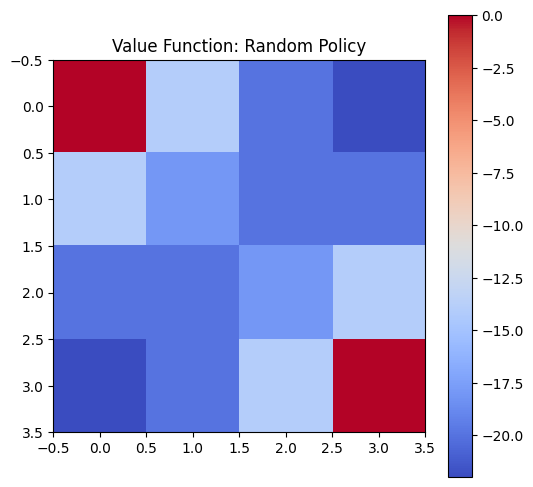

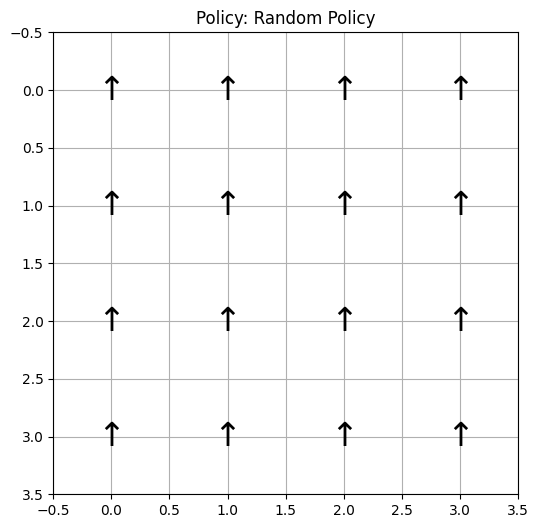

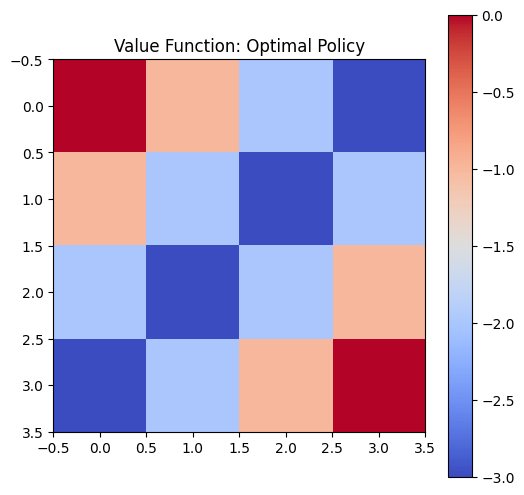

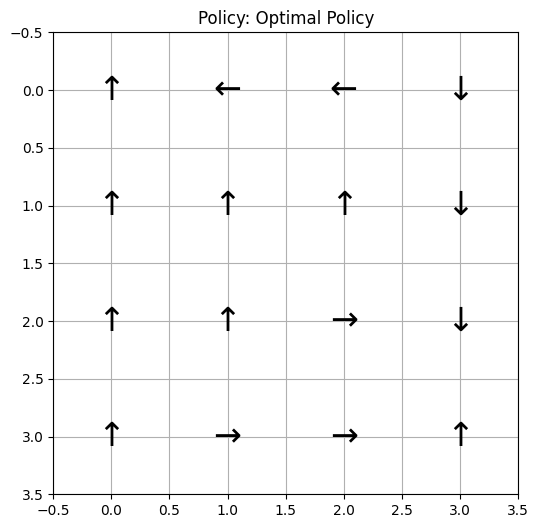

In [37]:
# Initial random policy
random_policy = np.ones([env.nS, env.nA]) / env.nA
V_random = policy_eval(random_policy, env)
plot_value_function(V_random, env.shape, title="Value Function: Random Policy")
plot_policy(random_policy, env.shape, title="Policy: Random Policy")

# After policy iteration
policy, V_opt = policy_improvement(env)
plot_value_function(V_opt, env.shape, title="Value Function: Optimal Policy")
plot_policy(policy, env.shape, title="Policy: Optimal Policy")